# Integrator

This example implements a one-dimensional neural integrator using an on-chip recurrent connection on the FPGA. It shows how neurons can be used to implement stable dynamics. Such dynamics are important for memory, noise cleanup, statistical inference, and many other dynamic transformations.

In standard control theoretic form, the dynamics of a state vector can be described as:
$$
\dot{x}(t) = \mathbf{A}x(t) + \mathbf{B}u(t)
$$

where $x(t)$ is the state vector, $u(t)$ is the time-varying input vector, $\mathbf{A}$ is the dynamics (feedback) matrix, and $\mathbf{B}$ is the input matrix. For an integrator, $\mathbf{A} = 0$ and $\mathbf{B} = 1$.

By applying the dynamics principal of the NEF, for a neural network using exponential synapses (like the FpgaPesEnsembleNetwork network), the feedback and input matrices can be converted into their equivalent neural forms with:
$$
\begin{align}
    \mathbf{A}' &= \tau\mathbf{A} + \mathbf{I}\\
    \mathbf{B}' &= \tau\mathbf{B}
\end{align}
$$

where $\mathbf{A}'$ is the neural feedback matrix, $\mathbf{B}'$ is the neural input matrix, and $\tau$ is the post-synaptic time constant of the feedback connection. For an integrator:
$$
\begin{align}
    \mathbf{A}' &= \tau \times 0 + \mathbf{I} = \mathbf{I}\\
    \mathbf{B}' &= \tau \times 1 = \tau
\end{align}
$$

This implies that the feedback transform should be an identity, and the input transform to the neural population should be scaled by $\tau$.

When you run this example, it will automatically put in some step functions on the input, so you can see that the output is integrating (i.e. summing over time) the input. You can also input your own values. Note that since the integrator constantly sums its input, it will saturate quickly if you leave the input non-zero. This makes it clear that neurons have a finite range of representation. Such saturation effects can be exploited to perform useful computations (e.g. soft normalization).

## Step 1: Set up the Python Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import nengo
from nengo.processes import Piecewise

import nengo_fpga
from nengo_fpga.networks import FpgaPesEnsembleNetwork

## Step 2: Choose an FPGA Device

Define the FPGA device on which the remote FpgaPesEnsembleNetwork will run. This name corresponds with the name in your `fpga_config` file. Recall that in the `fpga_config` file, device names are identified by the square brackets (e.g., **[de1]** or **[pynq]**). The names defined in your configuration file might differ from the example below. Here, the device **de1** is being used.

In [2]:
board = 'de1'  # Change this to your desired device name

## Step 3: Create an Input for the Model
We will use a piecewise step function as input, so we can see the effects of recurrence.

In [3]:
model = nengo.Network(label='Integrator')
# Create a piecewise step function for input
with model:
    input_node = nengo.Node(
        Piecewise({
            0: 0,
            0.2: 1,
            1: 0,
            2: -2,
            3: 0,
            4: 1,
            5: 0
        }))

## Step 4: Create the FPGA Ensemble

Create a remote FPGA neural ensemble (`FpgaPesEnsembleNetwork`) using the board defined above, 100 neurons, 1 dimensions, and with no learning rate. We will also specify the recurrent connection here.

In [4]:
tau = 0.05  # Synaptic time constant

with model:
    # Remote FPGA neural ensemble
    fpga_ens = FpgaPesEnsembleNetwork(
        board,  # The board to use (from above)
        n_neurons=100,  # The number of neurons to use in the ensemble
        dimensions=1,  # 1 dimensions
        learning_rate=0,  # No learning for this example
        feedback=1  # Activate the recurrent connection
    )

    # Setting `feedback=1` creates a `feedback` connection object
    # with the identity transform. You can set the attributes on this
    # feedback connection object, such as `.function` and `.transform`
    fpga_ens.feedback.synapse = tau  # `nengo.LowPass(tau)`

## Step 5: Connect Everything Together
The recurrent connection is housed on the FPGA device and is created as part of the `FpgaPesEnsembleNetwork` object, so the only connection that needs to be made is the input stimulus to the FPGA ensemble.

In [5]:
with model:
    # Connect the stimulus, with a scaling transform of tau
    nengo.Connection(input_node, fpga_ens.input,
                     synapse=tau, transform=tau)

## Step 6: Add Probes to Collect Data

In [6]:
with model:
    # The original input
    input_p = nengo.Probe(input_node)

    # The output from the FPGA ensemble
    # (filtered with a 10ms post-synaptic filter)
    output_p = nengo.Probe(fpga_ens.output, synapse=0.01)

## Step 7: Run the Model

In [7]:
with nengo_fpga.Simulator(model) as sim:
    sim.run(6)

## Step 8: Plot the Results

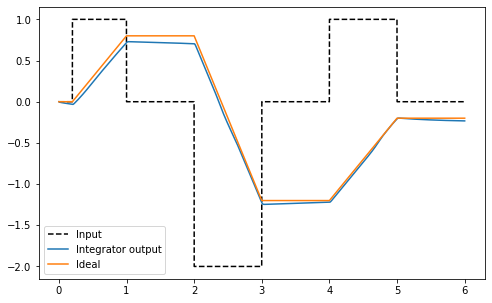

In [8]:
def plot_results():
    plt.figure(figsize=(8, 5))
    plt.plot(sim.trange(), sim.data[input_p], 'k--', label="Input")
    plt.plot(sim.trange(), sim.data[output_p], label="Integrator output")
    plot_ideal()
    plt.legend();


def plot_ideal():
    # Obtain the input function data from the input_node
    input_t = list(input_node.output.data.keys())
    input_v = list(input_node.output.data.values())

    # Construct the ideal output (assumes 1D signal)
    values = [[0]]
    input_t += [sim.trange()[-1]]
    for i, v in enumerate(input_v):
        values += [values[-1] + v * (input_t[i + 1] - input_t[i])]

    # Make the plot
    plt.plot(input_t, values, label="Ideal")


plot_results()

The plot above shows the neurons effectively integrating the input signal. Because of the implementation in neurons, the integration is not perfect (i.e., there will be some drift). Run the simulation several times to get a sense of the kinds of drift you might expect.

## Step 9: Spiking Neurons

The plots above demonstrate the results of an integrator network implemented with non-spiking rectified linear neurons. The network can also be simulated using spiking neurons to illustrate the similarities and differences between a spiking and a non-spiking network.

Below, we configure the FPGA neural ensemble to use spiking neurons, run the simulation, and plot the results.

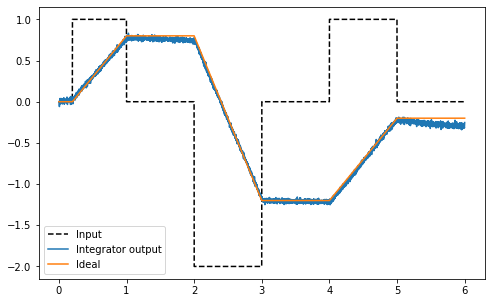

In [9]:
with model:
    fpga_ens.ensemble.neuron_type = nengo.SpikingRectifiedLinear()

with nengo_fpga.Simulator(model) as sim:
    sim.run(6)
plot_results()

The plot above shows that while the output differs from the non-spiking simulation (because the network parameters are regenerated when a new simulation is created), the performance of the spiking integrator still conforms to the expected output of an integrator.

## Step 10: Experiment!

Try playing around with the number of neurons in the FPGA ensemble as well as the synaptic time constant (`tau`) to see how it effects performance (e.g., observe how changing these numbers affect the drift)!